In [2]:
import numpy as np
import pandas as pd
import os
from datetime import datetime

In [3]:
import tensorflow as tf
print(tf. __version__) 
tf.config.list_physical_devices('GPU')

2.9.2


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [5]:
dir="data/"

In [6]:
df=pd.read_csv(dir+"GOOG.csv")  # read the data
df.head()  # print the summary of the data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-09-01,47.056499,47.124001,46.757500,46.867001,46.867001,18948000
1,2017-09-05,46.653999,46.849998,46.098000,46.422501,46.422501,26528000
2,2017-09-06,46.507500,46.545750,45.963501,46.390499,46.390499,30554000
3,2017-09-07,46.586498,46.820499,46.181000,46.797501,46.797501,24254000
4,2017-09-08,46.824501,46.849499,46.243999,46.325001,46.325001,20230000


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,82.767391,83.667386,81.913428,82.806675,82.806675,3.102087e+07
std,32.311184,32.633284,31.948660,32.277134,32.277134,1.359313e+07
min,45.870998,46.104000,45.485001,45.750000,45.750000,6.936000e+06
25%,56.346373,57.056126,55.833039,56.491998,56.491998,2.251200e+07
50%,67.585751,68.242001,67.174499,67.612747,67.612747,2.783600e+07
75%,113.282623,114.807499,112.140499,113.340628,113.340628,3.531300e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,1.241400e+08


In [7]:
df.isnull().sum().sum()  # check if there is any missing value

0

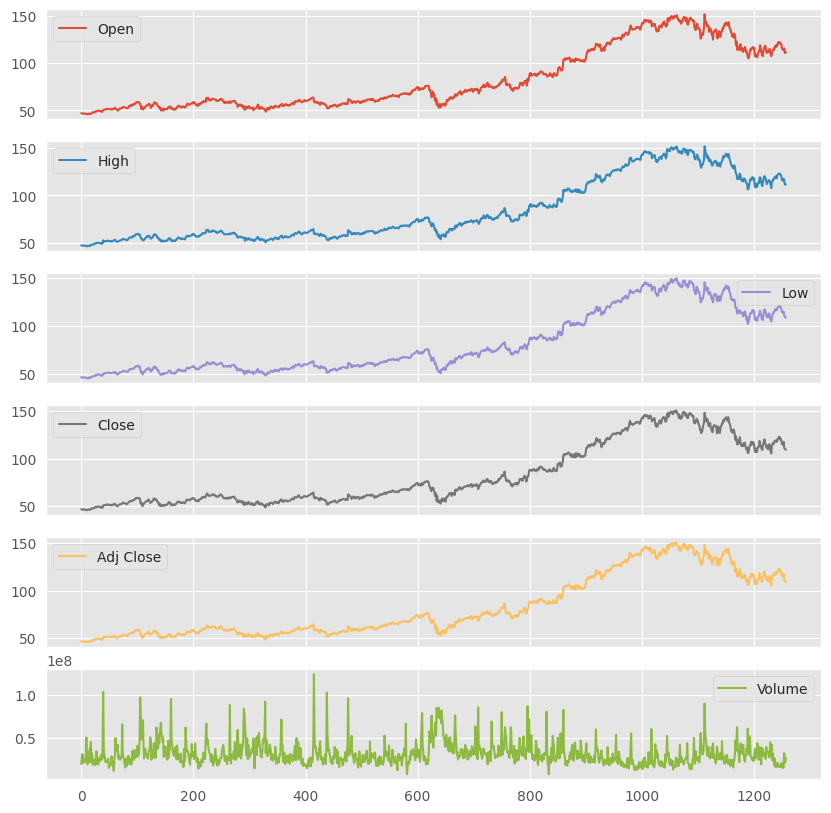

In [8]:
df.plot(legend=True,subplots=True, figsize=(10,10))  # plot the data
plt.show()

In [9]:
##Close Price

In [7]:
from sklearn.model_selection import train_test_split

X_close=[]
Y_close=[]
window_size=100

for i in range(1,len(df)-window_size):
    first=df.iloc[i,3]
    temp=[]
    temp2=[]
    for j in range(window_size):
        temp.append((df.iloc[i+j,3]-first)/first)
    temp2.append((df.iloc[i+window_size,3]-first)/first)
    X_close.append(np.array(temp).reshape(window_size,1))
    Y_close.append(np.array(temp2).reshape(1,1))

In [8]:
import tensorflow as tf

In [9]:
x_close_train, x_close_test, y_close_train, y_close_test = train_test_split(X_close, Y_close, test_size=0.2, random_state=42,shuffle=True)
x_close_train, x_close_test, y_close_train, y_close_test=np.array(x_close_train),np.array(x_close_test),np.array(y_close_train),np.array(y_close_test)
x_close_train=x_close_train.reshape(x_close_train.shape[0],1,window_size,1)
x_close_test=x_close_test.reshape(x_close_test.shape[0],1,window_size,1)

In [10]:
x_close_train.shape

(925, 1, 100, 1)

In [11]:
len(x_close_train)

925

In [12]:
##Train the model

In [13]:

from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
import pydot
from tensorflow.keras.models import Model

In [1]:
from tensorflow.keras.utils import plot_model
import pydot

In [25]:
model=tf.keras.Sequential()

model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])



In [14]:
def build_model():
    input_layer= tf.keras.Input(shape=(None,100, 1))
    
    cov_1=TimeDistributed(Conv1D(64, kernel_size=3, activation='relu'))(input_layer)
    pool_1=TimeDistributed(MaxPooling1D(2))(cov_1)
    cov_2=TimeDistributed(Conv1D(128, kernel_size=3, activation='relu'))(pool_1)
    pool_2=TimeDistributed(MaxPooling1D(2))(cov_2)
    cov_3=TimeDistributed(Conv1D(64, kernel_size=3, activation='relu'))(pool_2)
    pool_3=TimeDistributed(MaxPooling1D(2))(cov_3)
    flat=TimeDistributed(Flatten())(pool_3)
                          
    lstm_1=Bidirectional(LSTM(100, return_sequences=True))(flat)
    drop_1=Dropout(0.5)(lstm_1)
    lstm_2=Bidirectional(LSTM(100, return_sequences=False))(drop_1)
    drop_2=Dropout(0.5)(lstm_2)
    
    output_layer=Dense(1, activation='linear')(drop_2)
    
    func_model = Model(inputs=input_layer, outputs=output_layer)
    
    return func_model
    

In [21]:
model = build_model()

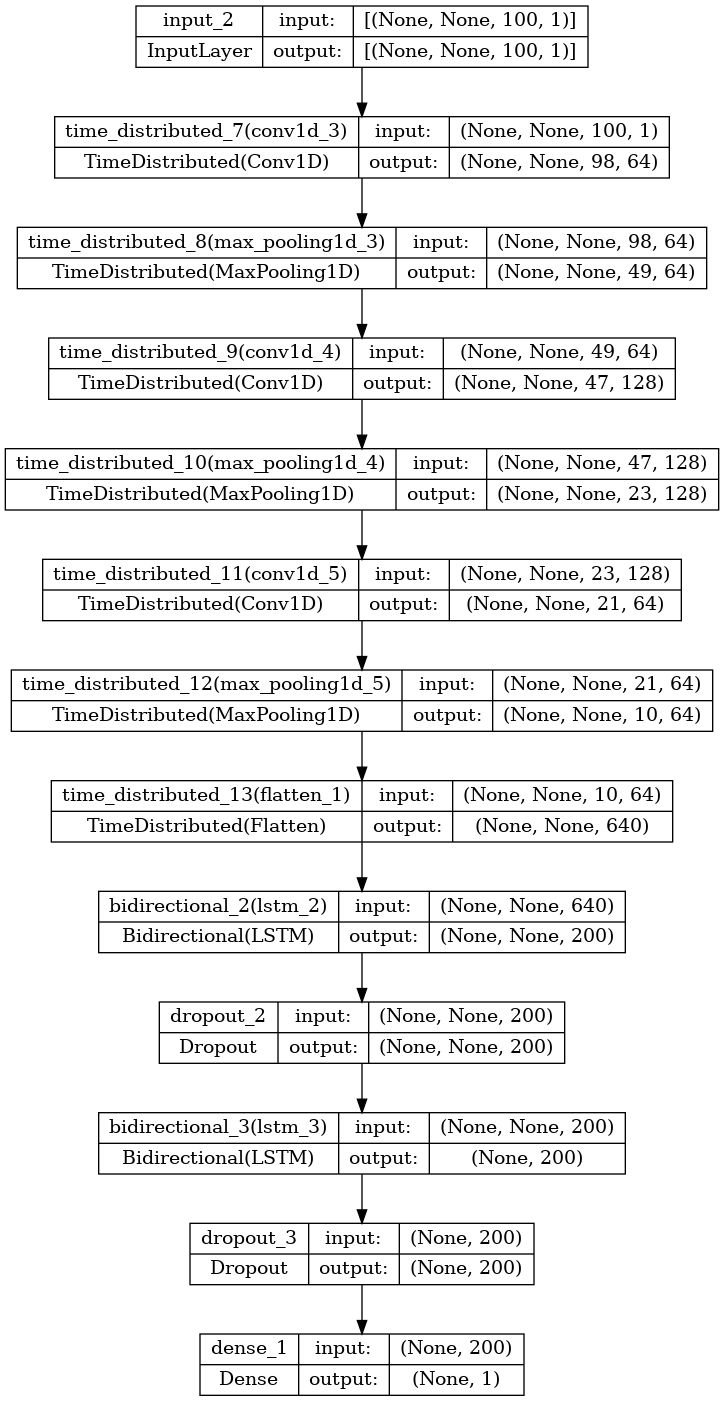

In [22]:
plot_model(model, show_shapes=True, show_layer_names=True,to_file='model.png')

In [37]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [38]:
model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae'])

In [39]:
history = model.fit(x_close_train, y_close_train, validation_data=(x_close_test,y_close_test), epochs=40,batch_size=40, verbose=1, shuffle =True)

Epoch 1/40
24/24 [==============================] - 5s 58ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0340 - val_loss: 22004.1270 - val_mse: 22004.1270 - val_mae: 146.5951
Epoch 2/40
24/24 [==============================] - 0s 17ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0360 - val_loss: 21998.9824 - val_mse: 21998.9824 - val_mae: 146.5790
Epoch 3/40
24/24 [==============================] - 0s 17ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0339 - val_loss: 22004.9141 - val_mse: 22004.9141 - val_mae: 146.6003
Epoch 4/40
24/24 [==============================] - 0s 15ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0337 - val_loss: 22006.8906 - val_mse: 22006.8906 - val_mae: 146.6061
Epoch 5/40
24/24 [==============================] - 0s 18ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0335 - val_loss: 21994.9258 - val_mse: 21994.9258 - val_mae: 146.5666
Epoch 6/40
24/24 [==============================] - 0s 15ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0348 - val_loss: 21999.6816 - va

In [26]:
predicted=model.predict(x_close_test)

8/8 [==============================] - 1s 21ms/step


In [27]:
predicted

array([[ 1.73928797e-01],
       [-4.71662655e-02],
       [ 2.09213614e-01],
       [ 1.13244690e-01],
       [ 9.56620201e-02],
       [ 8.42364505e-02],
       [ 3.41568619e-01],
       [-1.76980108e-01],
       [ 1.81394368e-01],
       [-3.84535566e-02],
       [ 3.36955786e-02],
       [ 2.15746552e-01],
       [ 2.49596640e-01],
       [ 2.42572188e-01],
       [ 4.14797887e-02],
       [-1.64998040e-01],
       [ 3.40293586e-01],
       [ 1.46893889e-01],
       [ 7.22157061e-02],
       [ 1.24715738e-01],
       [-6.50496557e-02],
       [ 1.47196382e-01],
       [-1.80561859e-02],
       [-1.65736660e-01],
       [ 8.68572816e-02],
       [-2.70902682e-02],
       [ 9.05251652e-02],
       [ 1.75462976e-01],
       [ 2.40775868e-01],
       [-1.60189271e-01],
       [ 1.90776363e-01],
       [ 1.66007727e-01],
       [-2.16692556e-02],
       [ 6.65901005e-02],
       [ 2.42661268e-01],
       [ 1.67670235e-01],
       [-1.99256256e-01],
       [-1.50720298e-01],
       [ 3.0

In [40]:
loss,rmse,mae=model.evaluate(x_close_test,y_close_test)

8/8 [==============================] - 0s 4ms/step - loss: 21999.4102 - mse: 21999.4102 - mae: 146.5811


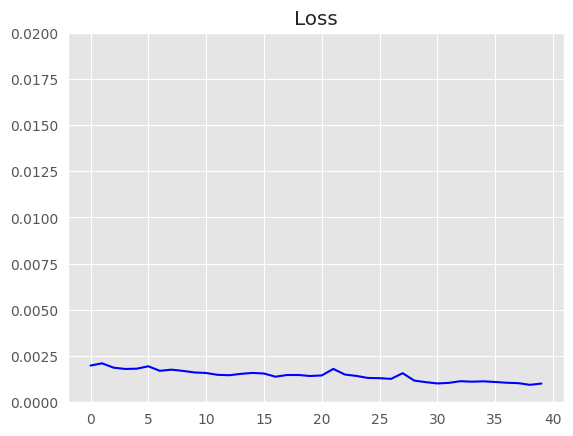

In [41]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss',title="Loss",ylim=0.02)

In [29]:
predicted=model.predict(x_close_test)
test_label=y_close_test.reshape(-1,1)
predicted=np.array(predicted[:,0]).reshape(-1,1)
len_train=len(x_close_train)

for j in range(len_train,len_train+len(x_close_test)):
    temp=df.iloc[j,3]
    predicted[j-len_train]=(predicted[j-len_train]+1)*temp
    test_label[j-len_train]=(test_label[j-len_train]+1)*temp

8/8 [==============================] - 0s 13ms/step


In [45]:
predicted

array([[138.42334 ],
       [113.04368 ],
       [133.75908 ],
       [126.13432 ],
       [126.32801 ],
       [125.88777 ],
       [153.44788 ],
       [ 98.72593 ],
       [136.48407 ],
       [112.76411 ],
       [118.3622  ],
       [139.90202 ],
       [149.50969 ],
       [149.62471 ],
       [126.63913 ],
       [ 99.60962 ],
       [170.9427  ],
       [135.93459 ],
       [129.90048 ],
       [132.88661 ],
       [119.867935],
       [140.27884 ],
       [123.29967 ],
       [103.93717 ],
       [135.66731 ],
       [120.71211 ],
       [135.1525  ],
       [148.80072 ],
       [162.715   ],
       [106.9433  ],
       [152.741   ],
       [146.79979 ],
       [129.45042 ],
       [126.04223 ],
       [160.35948 ],
       [142.82056 ],
       [102.19862 ],
       [109.01163 ],
       [167.2775  ],
       [129.0539  ],
       [158.25912 ],
       [ 98.53858 ],
       [121.20661 ],
       [176.67268 ],
       [143.07347 ],
       [156.76344 ],
       [171.74338 ],
       [165.3

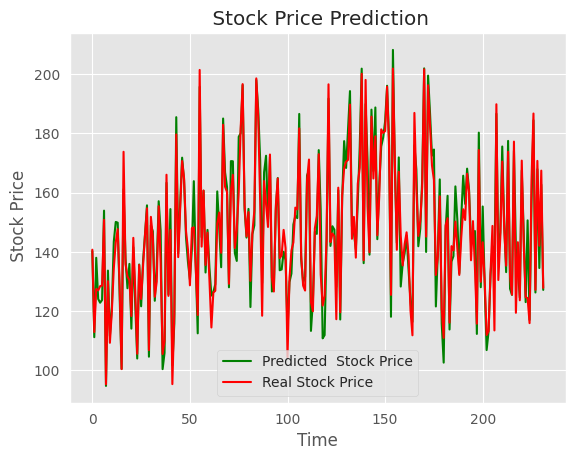

In [30]:
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()